# Meta Analysis
![](./images/Module5/Module5.jpg)
Meta pathway analysis using multiple omics data is a rapidly emerging field in bioinformatics and systems biology that allows for the integration of diverse omics data from genomics, transcriptomics, proteomics, metabolomics, and other molecular biology disciplines. By integrating multiple omics data, meta pathway analysis aims to provide a comprehensive understanding of the cellular functions and molecular mechanisms underlying biological processes in a given organism. This approach offers a powerful means to investigate the complex interplay between genes, proteins, and metabolites in different biological contexts, such as disease states or environmental conditions. Moreover, meta pathway analysis can identify key regulatory pathways and molecular signatures that are critical for the development of targeted therapeutics and precision medicine. Overall, the integration of multiple omics data through meta pathway analysis has the potential to reveal new insights into the underlying biology of complex diseases and to guide the development of personalized treatments. In this module we will demonstrate the power of meta analysis to find the significant pathways for Alzheimer and Parkinson diseases.

## Learning Objectives:
1. Downloading processed data
2. Performing enrichment analysis using FGSEA and plotting results
3. Performing meta-analysis and plotting results

## Loading datasets
In this sub-moodule 5 we will use datasets available from the Gene Expression Omnibus (GEO) repository. The datasets analyzed for Alzheimer disease is available under accession number `GSE5281`. This dataset contains genes that are preferentially expressed during the course of Alzheimer’s disease (AD) collected from 5 different brain regions: 1) entorhinal cortex (EC) 2) hippocampus (HIP) 3) medial temporal gyrus (MTG) 4) posterior cingulate 5) superior frontal gyrus and 6) primary visual cortex. In this sub-moodule, we will perform analysis using data generated from EC, HIP, and MTG.

The datasets analyzed for Parkinson disease is available under accession numbers `GSE99039` and `GSE20292`. The first dataset contains 558 blood-based gene signature characterizing Idiopathic Parkinson's disease while the second dataset has 29 transcriptional analysis of whole substantia nigra in Parkinson's disease. Users can follow instruction provided in sub-module 1 and 2 to download and perform genes ID mapping. In this sub-moduule, we will load the preprocessed data store in the course's Google bucket to perform analysis. The code to load all datasets is presented as follows:

In [3]:
# A vector to store all data IDs
data.IDs <- c("GSE5281-EC", "GSE5281-HIP", "GSE5281-MTG", "GSE99039", "GSE20292")
# A loop to read data information and store into a list
allData <- lapply(data.IDs, function(id){
  f <- paste0( "https://storage.googleapis.com/nosi-unr-data/", id, ".rds")
  if (!file.exists(f)) return(readRDS(url(f), "rb"))
  return(NULL)
})

## Installing required libraries
In this module we will install several libraries to perform enrichment analysis, meta analysis and visualization. We will install package `fgsea` to perform enrichment analysis. For visualization purpose, we will use `ggpubr` and `cowplot`. `ggpubr` provides a range of functions that enable users to create publication-ready plots, including barplots, box-plots, scatter plots, histograms, and heatmaps. `cowplot` provides ability to create custom layouts for complex multi-panel figures. The package includes functions for arranging plots in a grid, as well as for adding margins, padding, and labels. The package also includes features for aligning plots, adjusting font sizes and colors, and exporting plots to different file formats. To perform meta analysis, we will use `meta` R package which provides functions for conducting fixed-effect and random-effects meta-analyses, as well as for conducting sensitivity analyses, subgroup analyses, and meta-regression analyses. The package also provides tools for assessing the heterogeneity of the studies included in the analysis and for creating forest plots to visualize the results. Lastly, packages include `stringr` and `matrixStats` provide utility function to manipulate input matrices. The package `fgsea` can be download from Bioconductor while other packages can be installed from CRAN. The code to install all packages are presented below:

In [87]:
suppressMessages({if (!require("BiocManager", quietly = TRUE))
    suppressWarnings(install.packages("BiocManager"))
    suppressWarnings(if (!require("fgsea")) BiocManager::install("fgsea", update = F))
})

In [88]:
suppressMessages({
  # Installing all packages
  suppressWarnings(if (!require("stringr")) install.packages("stringr"))
  suppressWarnings(if (!require("meta")) install.packages("meta"))
  suppressWarnings(if (!require("matrixStats")) install.packages("matrixStats"))
  suppressWarnings(if (!require("cowplot")) install.packages("cowplot"))
  suppressWarnings(if (!require("ggpubr")) install.packages("ggpubr"))
  suppressWarnings(if (!require("dplyr")) install.packages("dplyr"))
  suppressWarnings(if (!require("tidyr")) install.packages("tidyr"))

  # Loading all packages
  suppressPackageStartupMessages({library(fgsea)})
  suppressPackageStartupMessages({library(stringr)})
  suppressPackageStartupMessages({library(meta)})
  suppressPackageStartupMessages({library(matrixStats)})
  suppressPackageStartupMessages({library(cowplot)})
  suppressPackageStartupMessages({library(ggpubr)})
  suppressPackageStartupMessages({library(dplyr)})
  suppressPackageStartupMessages({library(tidyr)})
})

## Utility functions
To perform enrichment analysis we will need to write several helper function to obtain pathway information from KEGG database.


In [90]:
getKEGGPathway <- function(org){
  suppressMessages({
    if (!require("BiocManager", quietly = TRUE))
    suppressWarnings(install.packages("BiocManager"))
    suppressWarnings(BiocManager::install("ROntoTools"))
  })
  keggPathway <- suppressMessages(ROntoTools::keggPathwayGraphs(organism = org,
                                                                updateCache=!cache,
                                                                verbose = FALSE,
                                                                relPercThresh = 0))
  return(keggPathway)
}

getKEGGGeneSet <- function(org){
  geneLink <- read.table(paste0("https://rest.kegg.jp/link/", org, "/pathway"),
                         sep = "\t", header = F,
                         stringsAsFactors = F);
  colnames(geneLink) <- c("geneset", "gene")

  geneLink <- geneLink %>%
           group_by(geneset) %>%
          group_split() %>%
          lapply(function(dat){
    list(
      name = dat$geneset[1] %>% as.character(),
      genes = dat$gene %>% as.character()
    )
  })

  names(geneLink) <- geneLink %>% lapply(function(gl) gl$name)
  geneLink <- geneLink %>% lapply(function(gl) gl$genes)

  keeps <- geneLink %>% lapply(length) %>% unlist() %>% `>=`(5) %>% which() %>% names()
  geneLink <- geneLink[keeps]
  return(geneLink)
}

getKEGGPathwayName <- function(org){
  gsNames <- read.table(paste0("https://rest.kegg.jp/list/pathway/", org),
                        sep = "\t",
                        header = F, stringsAsFactors = F);
  id <- gsNames[, 1]
  gsNames <- gsNames[,2]
  names(gsNames) <- id
  return(gsNames)
}

In [91]:
names(allData) <- data.IDs
allData <- allData[!sapply(allData, is.null)]
geneSet <- getKEGGGeneSet("hsa")
genes <- unique(unlist(geneSet))
perm <- 1000


In [93]:
allEnrichmentResult <- lapply(1:length(allData), function(iteration){
  set.seed(iteration)
  data <- allData[[iteration]]
  data <- data[[1]]
  exprs <- data$expression
  group <- data$group
  annotation <- data$annotation

  exprs <- exprs[intersect(genes, rownames(exprs)), ]


  control.samples <- names(group[group == "c"])
  disease.samples <- names(group[group == "d"])

  exprs <- as.matrix(exprs)
  snr <- (rowMeans(exprs[, disease.samples]) - rowMeans(exprs[, control.samples]))/(rowSds(exprs[, disease.samples]) + rowSds(exprs[, control.samples]))

  res <- suppressWarnings(fgsea(pathways = geneSet,
               stats = snr,
               nperm=perm))

  res$pvals$sample.size <- ncol(exprs)

  list(
    id = names(allData)[iteration],
    data = data,
    res = res
  )
})


In [43]:
names(allEnrichmentResult) <- names(allData)


In [44]:
plots.enrichment.data <- allEnrichmentResult %>% lapply(function(data){
  plot.data <- data$res
  rownames(plot.data) <- plot.data$pathway
  plot.data$dataset <- data$id
  plot.data$NES.sd = abs((plot.data$NES - ifelse(plot.data$NES > 0, 1, -1))/qnorm(plot.data$pval))

  sd <- plot.data$NES.sd

  sd[sd > 0.5] <- 0.5

  plot.data$min <- plot.data$NES - sd*2
  plot.data$max <- plot.data$NES + sd*2

  plot.data$min[plot.data$min < -2.5] <- -2.5
  plot.data$max[plot.data$max > 2.5] <- 2.5

  # ES.df <- as.data.frame(do.call(cbind, data$res$NEs))

  ES.df <- as.data.frame(data$res$ES)
  rownames(ES.df) <- names(geneSet)

  list(
    id = data$id,
    res = plot.data,
    ES = ES.df
  )
})


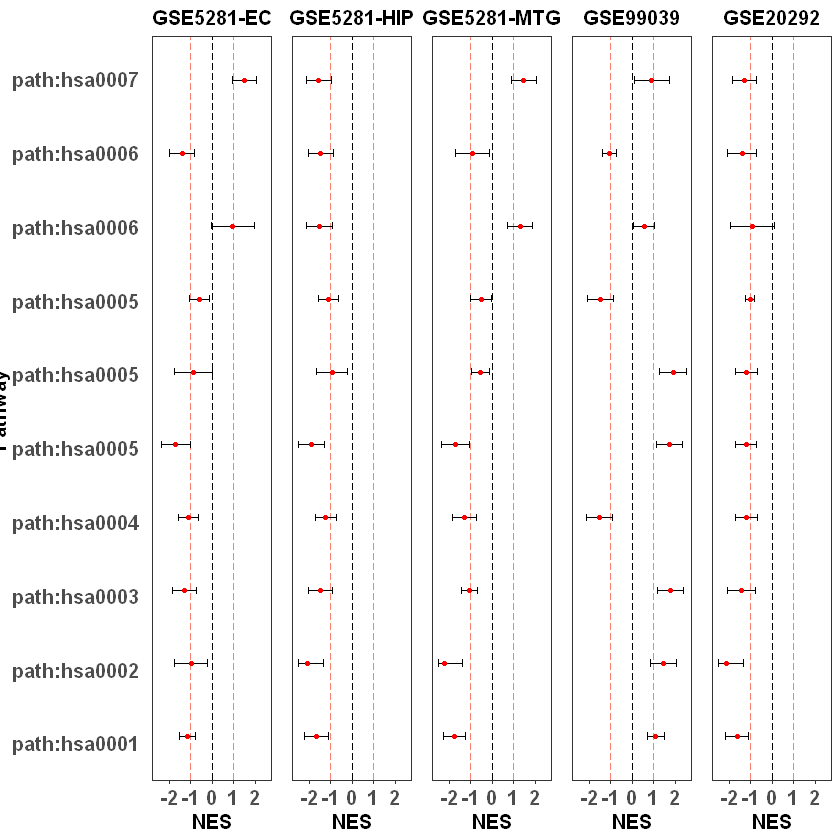

In [53]:
picked.pathways.names <- names(geneSet)[1:10]

plts <- plots.enrichment.data %>% lapply(function(data){
  name_plot <- data$id
  plot.data <- data$res
  plot.data <- plot.data %>%
    filter(pathway %in% picked.pathways.names)

  ggplot(plot.data, aes(y = pathway, x = NES, xmin = min, xmax = max)) +  theme_minimal() +
    geom_vline(xintercept = c(-1,1), colour="#FA8072", linetype = "longdash") +
    geom_vline(xintercept = c(0), colour="black", linetype = "longdash") +
    geom_errorbarh(height=.1) + theme_bw() +
    geom_point(size = 1, color = "red") +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
          plot.margin = unit(c(5,5,5,5), "pt"),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
          axis.text.x = element_text(face = "bold", size = 12),
          axis.title.x = element_text(face = "bold", size = 12)) +
    labs(x = "NES", title = name_plot) +
    xlim(-2.5, 2.5)
})


gridExtra::grid.arrange(grobs = c(
  list(
    ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +  labs(y = "Pathway", title = "", x = "") + theme_minimal() +
      theme(panel.grid.major.x = element_blank(), plot.margin = unit(c(2,0,2,5), "pt"), axis.text = element_text(face = "bold", size = 12), axis.title.y = element_text(face = "bold", size = 12))
  ),
  plts
), nrow = 1, widths = c(1, rep(1, length(plts))))


## Overlay of enrichment plots for datasets with the same disease (group)

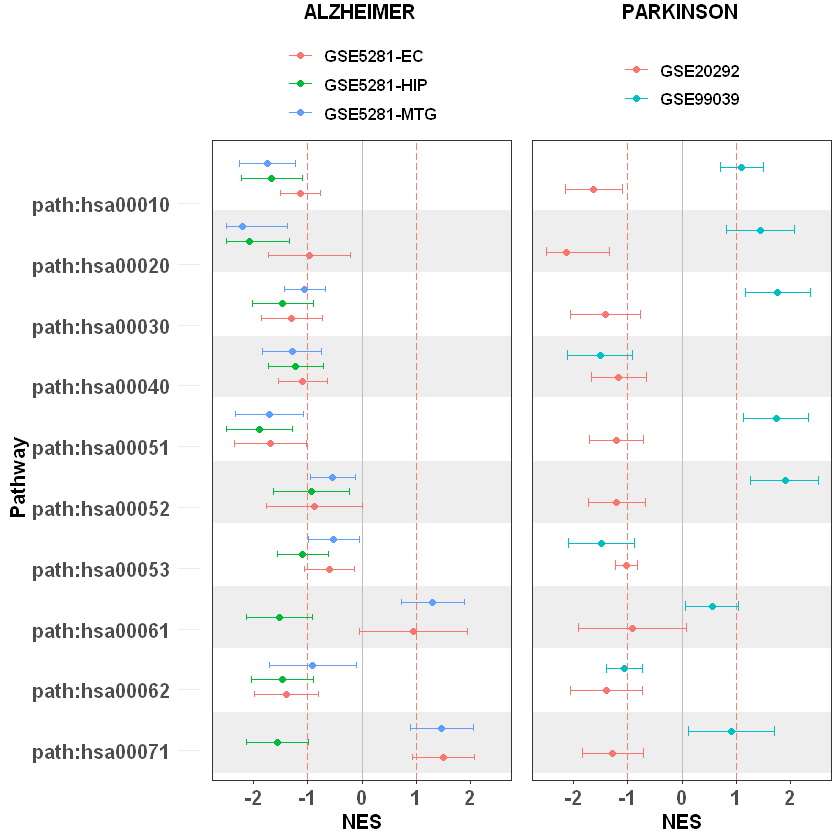

In [54]:
groups <- list(
  "ALZHEIMER" = c("GSE5281-EC", "GSE5281-HIP", "GSE5281-MTG"),
  "PARKINSON" = c("GSE99039", "GSE20292")
)

allCombinedData <- lapply(plots.enrichment.data, function(data) data$res)
allCombinedData <- as.data.frame(do.call(rbind, allCombinedData))
allCombinedData$disease <- "NA"


for (cat in names(groups)){
  allCombinedData$disease[allCombinedData$dataset %in% groups[[cat]]]  <- cat
}

allCombinedData <- allCombinedData %>% filter(pathway %in% picked.pathways.names)

plts <- allCombinedData %>% group_by(disease) %>% group_split() %>% lapply(function(data){
  data$pathway <- factor(data$pathway, levels = picked.pathways.names[length(picked.pathways.names):1])

  ggplot(data, aes(x=NES, y=pathway, group=dataset, col=dataset, fill=dataset)) +
    theme_minimal() +
    geom_point(position = position_dodge(0.7)) +
    geom_rect(
      aes(
        xmin=-Inf, xmax=Inf, ymin=as.numeric(pathway)-0.5, ymax=as.numeric(pathway)+0.5
      ),
      fill = ifelse((as.numeric(data$pathway)%%2 == 0), "white", "#eeeeee"),
      color = "white"
    ) +
    geom_point(position = position_dodge(0.7)) +
    geom_vline(xintercept = c(-1,1), colour="#FA8072", linetype = "longdash") +
    geom_vline(xintercept = c(0), colour="grey", linetype = "solid") +
    geom_errorbarh(height=.3, aes(xmin = min, xmax = max), position = position_dodge(0.7)) + theme_bw() +
    xlim(-2.5, 2.5) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
          plot.margin = unit(c(5,5,5,5), "pt"),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
          axis.text.x = element_text(face = "bold", size = 12),
          axis.title.x = element_text(face = "bold", size = 12),
          legend.position="top",
          legend.title = element_blank(),
          legend.text = element_text(face = "bold", size = 10)) +
    guides(color=guide_legend(ncol=1)) +
    labs(title = data$disease[1])
})



plotsAllLegends <- list()
plotsAllTitles <- list()

for(j in 1:length(plts)){
  p <- plts[[j]]
  legendP <- get_legend(p)
  titleP <- get_title(p)

  plotsAllLegends[[j]] <- legendP
  plotsAllTitles[[j]] <- titleP
}


plotsWithoutLegend <- lapply(plts, function(plt){
  plt <- plt + theme(legend.position = "none", title = element_blank(), plot.title = element_blank())
})

gs_titles <- lapply(plotsAllTitles, function(p)
  as_ggplot(p) + theme(
    legend.margin=margin(c(0,0,0,0))))

gs_legends <- lapply(plotsAllLegends, function(p)
  as_ggplot(p) + theme(
    legend.margin=margin(c(0,0,0,0))))

listAll <- c(gs_titles, gs_legends, c(
  list(
    ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +  labs(y = "Pathway", title = "", x = "") + theme_minimal() +
      theme(panel.grid.major.x = element_blank(), plot.margin = unit(c(2,0,2,5), "pt"), axis.text = element_text(face = "bold", size = 12), axis.title.y = element_text(face = "bold", size = 12))
  ),
  plotsWithoutLegend
))

gridExtra::grid.arrange(
  grobs = listAll,
  widths = c(5, rep(8,2)),
  heights = c(0.4, 1.1, 8),
  layout_matrix = rbind(c(NA, rep(1:2)),
                        c(NA, rep(3:4)),
                        c(rep(5:7)))
)


## Meta Analysis

In [57]:
allCombinedData <- lapply(plots.enrichment.data, function(data) data$res)
allCombinedData <- as.data.frame(do.call(rbind, allCombinedData))
allCombinedData$disease <- "NA"

for (cat in names(groups)){
  allCombinedData$disease[allCombinedData$dataset %in% groups[[cat]]]  <- cat
}

#Performing meta analysis on groups of datasets with the same disease
metaESRes <- allCombinedData %>% group_by(disease, pathway) %>% group_split() %>% lapply(function(data){
  data <- drop_na(data)

  res <- meta::metagen(data = data, studlab = pathway, TE = NES , seTE =NES.sd, sm = "SMD",
                       n.e = NULL,
                       #n.e = sample.size,
                       method.tau = "REML",
                       hakn = TRUE)


  NES.combined <- res$TE.fixed
  NES.combined.sd <- res$seTE.fixed

  pval <- pnorm((ifelse(NES.combined > 0, 1, -1) - NES.combined)/NES.combined.sd)
  if (NES.combined < 0) pval <- 1 - pval

  data.frame(
    disease = data$disease[1],
    pathway = data$pathway[1],
    NES.combined = NES.combined,
    NES.combined.sd = NES.combined.sd,
    pval.combined = pval,
    count = nrow(data),
    stringsAsFactors = F
  )
}) %>% do.call(what = rbind) %>% as.data.frame()

#Computing adjusted meta p-values
metaESRes <- metaESRes %>% group_by(disease) %>% group_split() %>% lapply(function(r){
  r$p.fdr <- p.adjust(r$pval.combined, method = "fdr")
  r
}) %>% do.call(what = rbind)


Warning message:
"Zero values in seTE replaced by NAs."
Warning message:
"Zero values in seTE replaced by NAs."
Warning message:
"Zero values in seTE replaced by NAs."
Warning message:
"Zero values in seTE replaced by NAs."
Warning message:
"Zero values in seTE replaced by NAs."
Warning message:
"Zero values in seTE replaced by NAs."
Warning message:
"Zero values in seTE replaced by NAs."
Warning message:
"Zero values in seTE replaced by NAs."


## Plot meta analysis


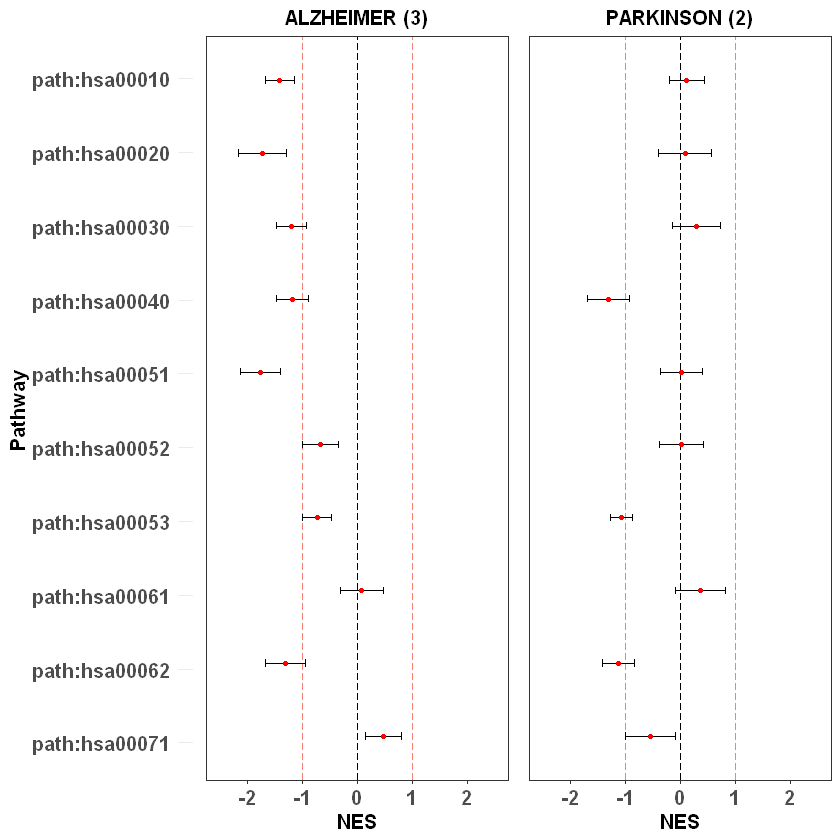

In [58]:
plts <- metaESRes %>% group_by(disease) %>% group_split() %>% lapply(function(plotDat){
  plotDat <- data.frame(plotDat)
  rownames(plotDat) <- plotDat$pathway
  plotDat <- plotDat[picked.pathways.names, ]
  plotDat$pathway <- factor(plotDat$pathway, levels = picked.pathways.names[length(picked.pathways.names):1])

  sd <- plotDat$NES.combined.sd
  sd[sd > 0.5] <- 0.5

  plotDat$min <- plotDat$NES.combined - sd*2
  plotDat$max <- plotDat$NES.combined + sd*2

  plotDat$min[plotDat$min < -2.5] <- -2.5
  plotDat$max[plotDat$max > 2.5] <- 2.5

  ggplot(plotDat, aes(y = pathway, x = NES.combined, xmin=min, xmax = max)) +  theme_minimal() +
    geom_vline(xintercept = c(-1,1), colour="#FA8072", linetype = "longdash") +
    geom_vline(xintercept = c(0), colour="black", linetype = "longdash") +
    geom_errorbarh(height=.1) + theme_bw() +
    geom_point(size = 1, color = "red") +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
          plot.margin = unit(c(5,5,5,5), "pt"),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
          axis.text.x = element_text(face = "bold", size = 12),
          axis.title.x = element_text(face = "bold", size = 12)) +
    labs(x = "NES", title = paste0(plotDat$disease[1], " (",plotDat$count[1],")")) +
    xlim(-2.5, 2.5)
})

gridExtra::grid.arrange(grobs = c(
  list(
    ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +  labs(y = "Pathway", title = "", x = "") + theme_minimal() +
      theme(panel.grid.major.x = element_blank(), plot.margin = unit(c(2,0,2,5), "pt"), axis.text = element_text(face = "bold", size = 12), axis.title.y = element_text(face = "bold", size = 12))
  ),
  plts
), nrow = 1, widths = c(0.6, rep(1, length(plts))))
